In [2]:
from formulas import *
import math
from sklearn import preprocessing, svm #scale, regresions, cross shuffle stats sepeareate data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import load_iris 
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
  

def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  
def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [4]:
df = yf.Ticker('TSLA').history(period="max").reset_index()
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0
...,...,...,...,...,...,...,...,...
3373,2023-11-21 00:00:00-05:00,235.039993,243.619995,233.339996,241.199997,122288000,0.0,0.0
3374,2023-11-22 00:00:00-05:00,242.039993,244.009995,231.399994,234.210007,117950600,0.0,0.0
3375,2023-11-24 00:00:00-05:00,233.750000,238.750000,232.330002,235.449997,65125200,0.0,0.0
3376,2023-11-27 00:00:00-05:00,236.889999,238.330002,232.100006,236.080002,112031800,0.0,0.0


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

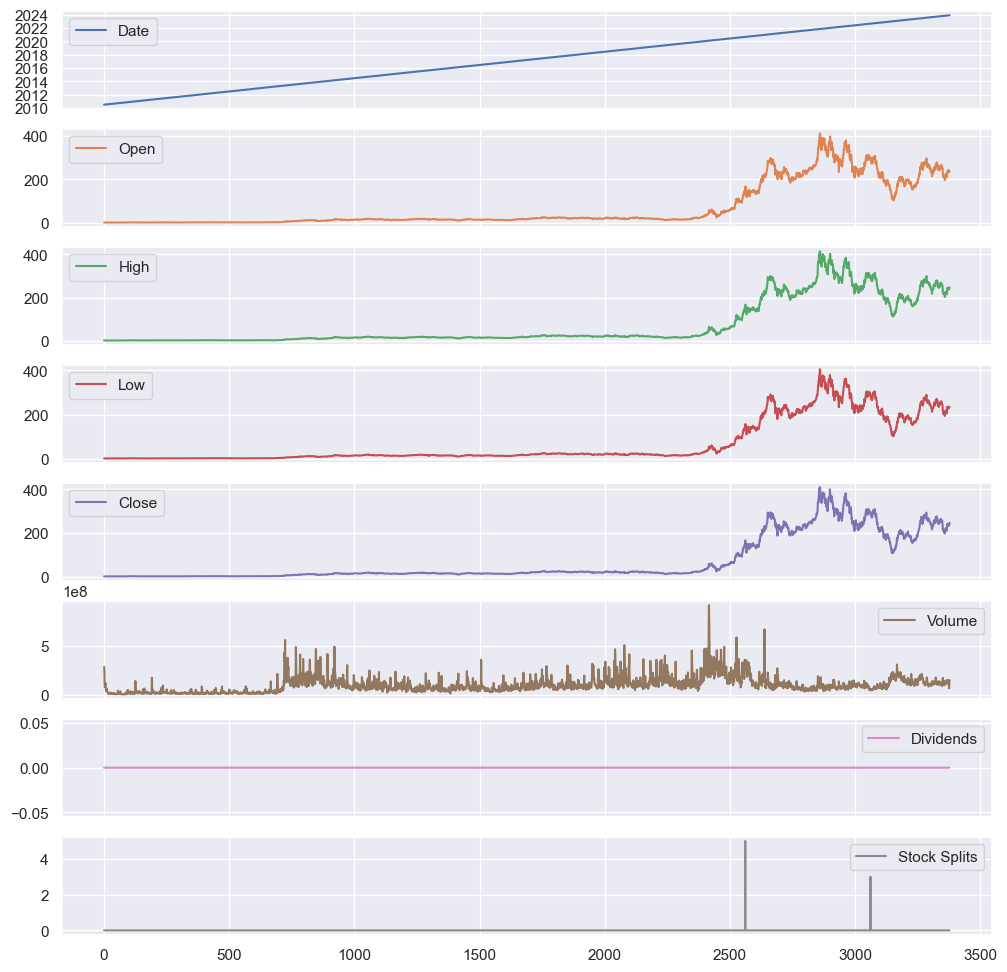

In [5]:
df.plot(kind="line",figsize=(12,12),subplots=True)

In [6]:
df.shape

(3378, 8)

In [7]:
series = df['Close']

# Create train data set
train_split_date = '2019-12-31'
train_split_index = np.where(df.Date == train_split_date)[0][0]
x_train = df.loc[df['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2021-12-01'
test_split_index = np.where(df.Date == test_split_date)[0][0]
x_test = df.loc[df['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = df.loc[(df['Date'] < test_split_date) & (df['Date'] > train_split_date)]['Close']

2393 2394 2876 2877 3377


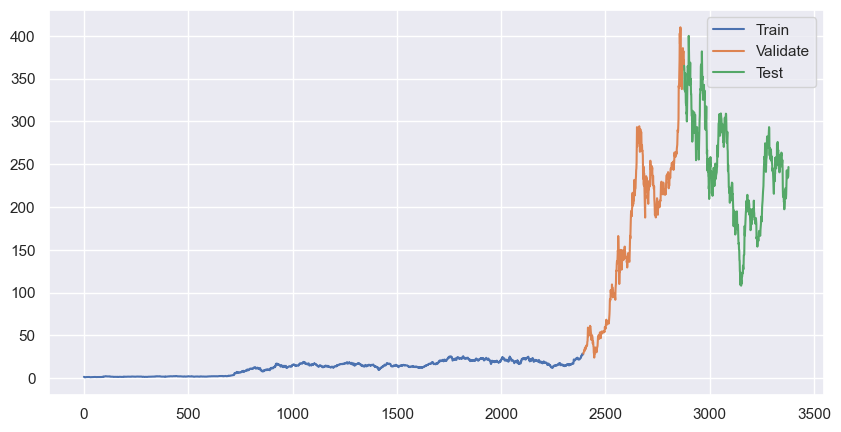

In [8]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [9]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

In [10]:
x_test.shape

(501,)

## Fully Convolutional Forecasting - Wavenet

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
19/19 [==============================] - 16s 255ms/step - loss: 0.1168 - mae: 0.3989 - lr: 1.0000e-04
Epoch 2/100
19/19 [==============================] - 2s 69ms/step - loss: 0.1098 - mae: 0.3826 - lr: 1.0798e-04
Epoch 3/100
19/19 [==============================] - 2s 70ms/step - loss: 0.0992 - mae: 0.3624 - lr: 1.1659e-04
Epoch 4/100
19/19 [==============================] - 2s 74ms/step - loss: 0.0812 - mae: 0.3342 - lr: 1.2589e-04
Epoch 5/100
19/19 [==============================] - 2s 80ms/step - loss: 0.0598 - mae: 0.2953 - lr: 1.3594e-04
Epoch 6/100
19/19 [==============================] - 2s 95ms/step - loss: 0.0369 - mae: 0.2385 - lr: 1.4678e-04
Epoch 7/100
19/19 [==============================] - 2s 84ms/step - loss: 0.0211 - mae: 0.1755 - lr: 1.5849e-04
Epoch 8/100
19/19 [==============================] - 2s 99ms/step - loss: 0.0167 - mae: 0.1520 - lr: 1.7113e-04
Epoch 9/100
19/19 [==============================] - 2s 88ms/step - loss: 0.0136 - mae: 0.1351 - lr: 1

(0.0001, 0.1, 0.0, 0.1)

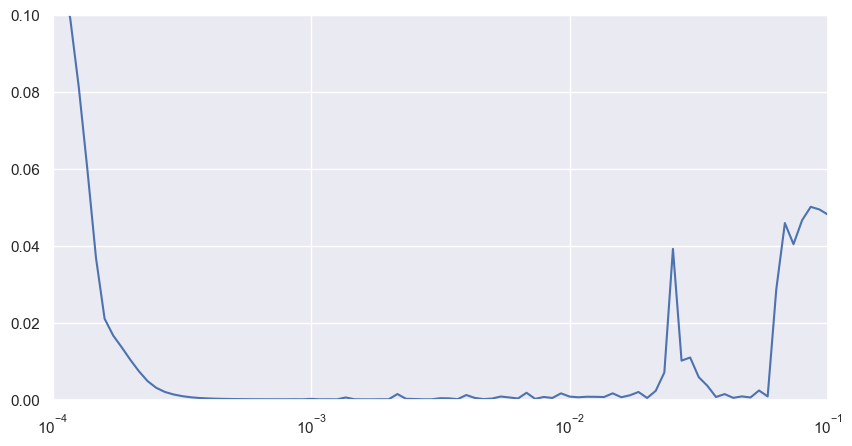

In [11]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .1])

In [12]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=5e-4)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=200,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/200
19/19 [==============================] - 6s 175ms/step - loss: 0.0254 - mae: 0.1732 - val_loss: 1.2385 - val_mae: 1.6723
Epoch 2/200


C:\Users\satvi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 3s 131ms/step - loss: 0.0069 - mae: 0.0975 - val_loss: 0.5994 - val_mae: 1.0105
Epoch 3/200
19/19 [==============================] - 3s 129ms/step - loss: 7.3257e-04 - mae: 0.0304 - val_loss: 0.0971 - val_mae: 0.3059
Epoch 4/200
19/19 [==============================] - 3s 134ms/step - loss: 3.7014e-04 - mae: 0.0201 - val_loss: 0.1346 - val_mae: 0.3907
Epoch 5/200
19/19 [==============================] - 3s 119ms/step - loss: 2.6980e-04 - mae: 0.0166 - val_loss: 0.1149 - val_mae: 0.3531
Epoch 6/200
19/19 [==============================] - 3s 125ms/step - loss: 2.3226e-04 - mae: 0.0150 - val_loss: 0.0936 - val_mae: 0.3102
Epoch 7/200
19/19 [==============================] - 3s 110ms/step - loss: 2.0826e-04 - mae: 0.0139 - val_loss: 0.0899 - val_mae: 0.3048
Epoch 8/200
19/19 [==============================] - 3s 117ms/step - loss: 1.9761e-04 - mae: 0.0134 - val_loss: 0.0722 - val_mae: 0.2662
Epoch 9/200
19/19 [==============================] - 3s 1

In [13]:
# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

In [14]:
# Use best model to get forecasts
cnn_forecast = model_forecast(model, spy_normalized_to_traindata[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[x_test.index.min() - window_size:-1,-1,0]

105/105 [==============================] - 3s 12ms/step


In [15]:
# Scale back to normal
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

(485,)

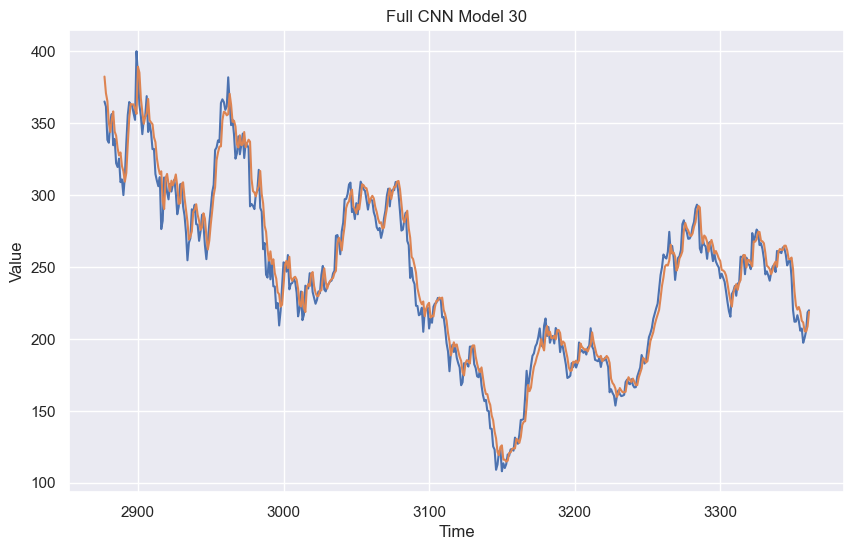

In [16]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plot_series(x_test.index, x_test)
plot_series(x_test.index, cnn_unscaled_forecast)

In [17]:
# Calculate MAE
cnn_mea=keras.metrics.mean_absolute_error(x_test, cnn_unscaled_forecast).numpy()
cnn_mea

8.3507

In [18]:
# Calculate RMSE
cnn_rmse = np.sqrt(mean_squared_error(x_test, cnn_unscaled_forecast))
print(f"Root Mean Square Error (RMSE): {cnn_rmse}")


Root Mean Square Error (RMSE): 10.992284381011027


In [101]:
sn=StockNews('MSFT', save_news=False)
df_news= sn.read_rss()
df_news

,guid,stock,title,summary,published,p_date,sentiment_summary,sentiment_title
0,87214d52-f687-3d41-abca-c6135a517e3b,M,Macy's (M) Collaborates With Gap on Sleepwear ...,Macy's (M) partners with Gap to provide a dive...,"Wed, 30 Aug 2023 15:47:00 +0000",M_2023-08-30,0.0000,0.0000
1,23b33b01-bb1d-3f3d-95d3-ad2b7b53c705,M,"At US$12.26, Is It Time To Put Macy's, Inc. (N...","Macy's, Inc. ( NYSE:M ), is not the largest co...","Wed, 30 Aug 2023 10:59:05 +0000",M_2023-08-30,0.0000,0.0000
2,faad3cc0-3fb6-34a8-a81c-677ee996fb93,M,Gap and Macy’s to Work Together as Competition...,"A new line of Gap sleepwear and intimates, to ...","Tue, 29 Aug 2023 14:36:00 +0000",M_2023-08-29,0.0000,0.0000
3,a7188c69-7b26-4467-ba97-a375c57f8e7c,M,Best Buy joins retailers warning that shoppers...,Best Buy sounds the alarm on credit card payme...,"Tue, 29 Aug 2023 13:23:24 +0000",M_2023-08-29,0.6597,0.2960
4,cefe3de1-06f7-33f5-ba85-9d5a8ebbc561,M,Macy’s and Gap Launch Sleepwear and Intimates ...,"NEW YORK, August 29, 2023--Today, Macy’s annou...","Tue, 29 Aug 2023 13:16:00 +0000",M_2023-08-29,0.7964,0.0000
...,...,...,...,...,...,...,...,...
75,ccdefc5b-ba83-3824-aa76-48f8419acdf9,T,"Midday movers: Best Buy, 3M, Salesforce and more",Investing.com -- U.S. stocks are rising as inv...,"Tue, 29 Aug 2023 13:19:57 +0000",T_2023-08-29,-0.4019,0.6369
76,e45611c1-909e-3430-b5d6-f43ef2ba6c8f,T,"AT&T Gains a Buy Recommendation, but I Think I...",AT&amp;T (T) shares were raised to a buy recom...,"Tue, 29 Aug 2023 12:00:00 +0000",T_2023-08-29,-0.4406,0.1779
77,6a4b8b81-389a-39e5-a716-311bdffe9e31,T,5 Things to Know Before Markets Open,Data due for release is expected to show home ...,"Tue, 29 Aug 2023 11:17:00 +0000",T_2023-08-29,0.1280,0.0000
78,61a8a4a0-7ffc-360d-9ec3-9a7096e0e936,T,The 1 Move That Would Make Me a Verizon Stock ...,Verizon (NYSE: VZ) is a stock of contradiction...,"Tue, 29 Aug 2023 11:00:00 +0000",T_2023-08-29,-0.6705,0.0000
